# Lista prática IV

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

**Dica:** Considere usar o Google Colab

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [9]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [ ]:
# Seu código aqui

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [ ]:
# Seu código aqui

# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.** 

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


cuda:0
Files already downloaded and verified
Files already downloaded and verified


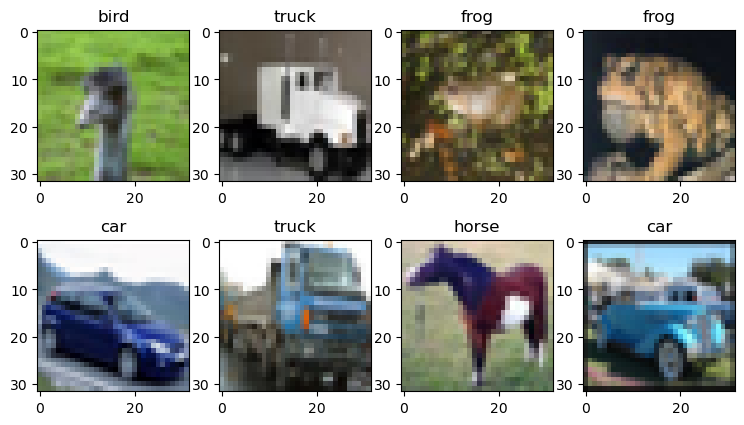

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0
    for data in train_loader:
        if aux == 0 and epoch == 0:
            print('this is how to load a training batch')
        aux += 1
